In [16]:
 import pandas as pd
import seaborn as sns
import numpy as np
import csv
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers, utils, initializers

from sklearn.model_selection import train_test_split

# Fingerprinting

In this notebook, we are doing fingerprinting on BLE packets, meaning that we are trying to identify an emitter based on the traffic it emits. We are using data from Scenario 5, in which the emitter and the server are still, using 3 nRF52 dev kits used as BLE advertising devices, 4 USRPs used as receivers. We are using raw IQ data as input. We are using data solely from Scene 36 and Scene 37 in which only one emitter is advertising. In Scene 36 it is a nRF52 apuP22, and in Scene 37 it is nRF52 apuQ2. This means that we only have two classes. We are using data solely from one server.

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
files=('../data/processed/scenario5_scene36.csv','../data/processed/scenario5_scene37.csv')

idata = pd.concat([pd.read_csv(f) for f in files])

In [21]:
idata_five=idata[idata['Scenario']==5] 
print(idata_five.tail())

                                Time  Len Packet  Central Frequency     X   Y  \
1426075  2020-11-12T16:07:36.897782Z        1520         2480000000  3009  94   
1426076  2020-11-12T16:07:36.897782Z        1520         2480000000  3009  94   
1426077  2020-11-12T16:07:36.897782Z        1520         2480000000  3009  94   
1426078  2020-11-12T16:07:36.897782Z        1520         2480000000  3009  94   
1426079  2020-11-12T16:07:36.897782Z        1520         2480000000  3009  94   

                                      IQ      real        im  Server_id  \
1426075     (6.103679e-05+6.103679e-05j)  0.000061  0.000061         11   
1426076                   0.00021362878j  0.000000  0.000214         11   
1426077  (-0.00012207359+0.00021362878j) -0.000122  0.000214         11   
1426078   (-0.00030518396-6.103679e-05j) -0.000305 -0.000061         11   
1426079  (-0.00012207359+0.00021362878j) -0.000122  0.000214         11   

         Robot_node  Scenario  Scene  
1426075         NaN    

In [22]:
idata_sc=idata_five[(idata_five['Scene']==36) | (idata_five['Scene']==37)]
print(len(idata_sc.index))

3079000


In [23]:
print(idata_sc['Scene'].value_counts())

36    1652920
37    1426080
Name: Scene, dtype: int64


In [24]:
print(idata_sc['Len Packet'].value_counts())

print(idata_sc['Server_id'].value_counts())

1520    2932080
1880      71440
1360      53040
1320      17160
880        5280
Name: Len Packet, dtype: int64
9     877480
11    856880
15    708720
12    635920
Name: Server_id, dtype: int64


We are selecting the most represented packet length, in order to have a constant input length for the CNN.

In [25]:
pkt_len=1520
#using only one pkt length for the time being
idata_red=idata_sc[idata_sc['Len Packet']==pkt_len]
idata_red=idata_red[idata_red['Server_id']==9]

We are creating input for the CNN: X is composed of 1520 IQ samples, and Y is the scene number, meaning the emitter used in each of these scenes.

In [26]:
#creating input for CNN: IQ values for a whole pkt     output: robot_node
X=list()
Y=list()

i=0
while i<len(idata_red.index):
    data=idata_red.iloc[i:i+pkt_len]
    if len(data['Time'].unique())==1:
        data=np.array(data[['real','im']], dtype='float64')
        x=data.reshape(pkt_len,2,1)
        X.append(x)
        Y.append(int(idata_red.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
    else:
        print('Missing!!')
    i=i+pkt_len

X=np.array(X)
Y=np.array(Y, dtype=int)

In [27]:
print("Il y a "+str(len(Y))+" échantillons")

Il y a 541 échantillons


In [28]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print(unique_elements)
print(counts_elements)

[36 37]
[299 242]


We are manually balancing the classes to make classification easier and avoid bias due to class imbalance.

In [29]:
#balance classes
min_samples=min(counts_elements)
print(min_samples)

thirty_six_index=np.where(Y == 36)
thirty_six_index=thirty_six_index[0][:min_samples]
X_thirty_six=X[thirty_six_index]
Y_thirty_six=Y[thirty_six_index]

thirty_seven_index=np.where(Y == 37)
thirty_seven_index=thirty_seven_index[0][:min_samples]
X_thirty_seven=X[thirty_seven_index]
Y_thirty_seven=Y[thirty_seven_index]

X=np.concatenate((X_thirty_six, X_thirty_seven))
Y=np.concatenate((Y_thirty_six, Y_thirty_seven))

242


In [30]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print(unique_elements)
print(counts_elements)

[36 37]
[242 242]


## First try : CNN

In [31]:

#using Thibaud network
from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size=100
steps=500

Y_change=list()

#36:0, 37:1
for i in Y:
    if i==36:
        Y_change.append(0)
    elif i==37:
        Y_change.append(1)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1


        
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)


model = models.Sequential()
model.add(layers.Conv2D(32, (6,2), padding='valid',activation='relu', kernel_constraint=min_max_norm(min_value=1, max_value=1.0),input_shape=(pkt_len,2, 1)))
model.add(layers.MaxPooling2D((2,1), strides=2))
#model.add(layers.Conv2D(32, (8,1), padding='valid',activation='relu',kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0)))
#model.add(layers.MaxPooling2D((4,1), strides=4))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(nb_class, activation='softmax'))


model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])



history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 class_weight=class_weights)

i = np.arange(steps)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(i, history.history['accuracy'], label='accuracy')
plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

Num GPUs Available:  4
{0: 1.0, 1: 1.0}
Epoch 1/500


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_2/conv2d_2/Conv2D (defined at <ipython-input-31-1311771fe8ea>:61) ]] [Op:__inference_train_function_2604]

Function call stack:
train_function


In [ ]:
predictions= model.predict(X_test)

predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, average_precision_score

present_class_list=np.unique(y_test_cat)
print(present_class_list)

# Confusion Matrix
conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)
print("Conf mat")
print(conf_mat)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_test_cat, predictions, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_test_cat,predictions))


import seaborn as sns
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

The Accuracy and F1-score are good for a first try, but we need to tune the model to make it more efficient.

## Tuning 1

Let's use Keras Hypertuner on this network. This tool allows us to select a range of values for a given hyperparameter, and to try various combinations of these hyperparameters. After a given number of execution, the best combination according to a given metric is selected.

In [82]:
from tensorflow.keras import layers, optimizers
from kerastuner.tuners import RandomSearch, Hyperband

input_shape=(1520,2,1)

def build_model(h):
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=h.Int('filters_1', 2, 200,10, default=32), kernel_size=(6, 2), padding='valid',activation=h.Choice(
                'activation_1',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'), kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0),input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 1), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=h.Int('units_dense', 2, 200,10, default=100), activation=h.Choice(
                'activation_2',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu')))
    model.add(layers.Dropout(
            h.Float(
                'dropout',
                min_value=0.5,
                max_value=0.9,
                default=0.7,
                step=0.1)
        )
    )

    model.add(layers.Dense(nb_class, activation='softmax'))

    hp_learning_rate = h.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=optimizers.Adam(learning_rate = hp_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
    
    return model

In [83]:
#trying first simple CNN to test if our data are ok
#using Thibaud network
from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size=100
steps=300

Y_change=list()

#36:0, 37:1
for i in Y:
    if i==36:
        Y_change.append(0)
    elif i==37:
        Y_change.append(1)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1


        
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)

Num GPUs Available:  1
{0: 1.0, 1: 1.0}


In [84]:
tuner_rs = RandomSearch(
            build_model,
    objective='val_accuracy',
            seed=42,
            max_trials=20,
            executions_per_trial=2,
            overwrite=True)

tuner_rs.search_space_summary()



tuner_rs.search(X_train, y_train, epochs=300, validation_split=0.2, verbose=1, class_weight=class_weights)

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 51s]
val_accuracy: 0.5256410241127014

Best val_accuracy So Far: 0.9871794879436493
Total elapsed time: 00h 17m 24s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters_1: 52
activation_1: tanh
units_dense: 162
activation_2: relu
dropout: 0.7999999999999999
learning_rate: 0.001
Score: 0.9871794879436493
Trial summary
Hyperparameters:
filters_1: 62
activation_1: tanh
units_dense: 182
activation_2: tanh
dropout: 0.7
learning_rate: 0.001
Score: 0.9743589758872986
Trial summary
Hyperparameters:
filters_1: 162
activation_1: relu
units_dense: 52
activation_2: sigmoid
dropout: 0.6
learning_rate: 0.001
Score: 0.9743589758872986
Trial summary
Hyperparameters:
filters_1: 12
activation_1: tanh
units_dense: 172
activation_2: tanh
dropout: 0.6
learning_rate: 0.001
Score: 0.9743589460849762
Trial summary
Hyperparameters:
filters_1: 11

## Test optimal CNN

In [15]:

#using Thibaud network
from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


batch_size=100
steps=300

Y_change=list()

#36:0, 37:1
for i in Y:
    if i==36:
        Y_change.append(0)
    elif i==37:
        Y_change.append(1)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)
input_shape=(1520,2,1)

model = models.Sequential()
model.add(layers.Conv2D(filters=52, kernel_size=(6, 2), padding='valid',activation='tanh', kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0),input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 1), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=162, activation='tanh'))
model.add(layers.Dropout(0.8)
)

model.add(layers.Dense(nb_class, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])



history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 class_weight=class_weights)

i = np.arange(steps)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(i, history.history['accuracy'], label='accuracy')
plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

Num GPUs Available:  4
{0: 1.0, 1: 1.0}
Epoch 1/300


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv2d_1/Conv2D (defined at <ipython-input-15-778c27fcf08f>:58) ]] [Op:__inference_train_function_1737]

Function call stack:
train_function


In [89]:
predictions= model.predict(X_test)

predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]


[0 1]
Conf mat
[[43  3]
 [ 3 48]]
f1_score for each class
[0.93478261 0.94117647]
Global f1_score
0.9381443298969072
Global accuracy
0.9381443298969072


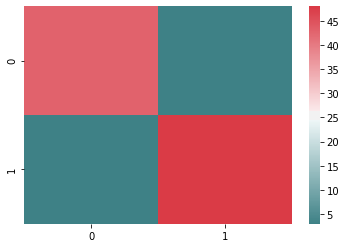

In [90]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, average_precision_score

present_class_list=np.unique(y_test_cat)
print(present_class_list)

# Confusion Matrix
conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)
print("Conf mat")
print(conf_mat)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_test_cat, predictions, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_test_cat,predictions))


import seaborn as sns
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

## 2 layers

In [66]:
#creating input for CNN: IQ values for a whole pkt     output: robot_node
X=list()
Y=list()

i=0
while i<len(idata_red.index):
    data=idata_red.iloc[i:i+pkt_len]
    if len(data['Time'].unique())==1:
        data=np.array(data[['real','im']], dtype='float64')
        x=data.reshape(pkt_len,2,1)
        X.append(x)
        Y.append(int(idata_red.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
    else:
        print('Missing!!')
    i=i+pkt_len

X=np.array(X)
Y=np.array(Y, dtype=int)

In [67]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print(unique_elements)
print(counts_elements)
#balance classes
min_samples=min(counts_elements)
print(min_samples)

thirty_six_index=np.where(Y == 36)
thirty_six_index=thirty_six_index[0][:min_samples]
X_thirty_six=X[thirty_six_index]
Y_thirty_six=Y[thirty_six_index]

thirty_seven_index=np.where(Y == 37)
thirty_seven_index=thirty_seven_index[0][:min_samples]
X_thirty_seven=X[thirty_seven_index]
Y_thirty_seven=Y[thirty_seven_index]

X=np.concatenate((X_thirty_six, X_thirty_seven))
Y=np.concatenate((Y_thirty_six, Y_thirty_seven))

[36 37]
[299 242]
242


In [68]:
from tensorflow.keras import layers, optimizers
from kerastuner.tuners import RandomSearch, Hyperband

input_shape=(1520,2,1)

def build_model(h):
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=h.Int('filters_1', 2, 200,10, default=32), kernel_size=(6, 2), padding='valid',activation=h.Choice(
                'activation_1',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'), kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0),input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 1), strides=2))
    model.add(layers.Conv2D(filters=h.Int('filters_2', 2, 200,10, default=32), kernel_size=(8,1), padding='valid',activation=h.Choice(
                'activation_2',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'),kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0)))
    model.add(layers.MaxPooling2D((4,1), strides=4))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=h.Int('units_dense', 2, 200,10, default=100), activation=h.Choice(
                'activation_3',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu')))
    model.add(layers.Dropout(
            h.Float(
                'dropout',
                min_value=0.5,
                max_value=0.9,
                default=0.7,
                step=0.1)
        )
    )

    model.add(layers.Dense(nb_class, activation='softmax'))

    hp_learning_rate = h.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=optimizers.Adam(learning_rate = hp_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
    
    return model

In [69]:
#trying first simple CNN to test if our data are ok
#using Thibaud network
from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size=100
steps=500

Y_change=list()

#36:0, 37:1
for i in Y:
    if i==36:
        Y_change.append(0)
    elif i==37:
        Y_change.append(1)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1


        
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)

Num GPUs Available:  1
{0: 1.0, 1: 1.0}


In [70]:
tuner_rs = RandomSearch(
            build_model,
    objective='val_accuracy',
            seed=42,
            max_trials=20,
            executions_per_trial=2,
            overwrite=True)

tuner_rs.search_space_summary()



tuner_rs.search(X_train, y_train, epochs=300, validation_split=0.2, verbose=1, class_weight=class_weights)

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 01m 13s]
val_accuracy: 0.5256410241127014

Best val_accuracy So Far: 0.967948704957962
Total elapsed time: 00h 21m 19s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters_1: 112
activation_1: relu
filters_2: 62
activation_2: tanh
units_dense: 182
activation_3: tanh
dropout: 0.7
learning_rate: 0.001
Score: 0.967948704957962
Trial summary
Hyperparameters:
filters_1: 172
activation_1: tanh
filters_2: 72
activation_2: tanh
units_dense: 162
activation_3: relu
dropout: 0.6
learning_rate: 0.0001
Score: 0.8717948496341705
Trial summary
Hyperparameters:
filters_1: 102
activation_1: relu
filters_2: 192
activation_2: relu
units_dense: 112
activation_3: relu
dropout: 0.8999999999999999
learning_rate: 0.0001
Score: 0.7435897588729858
Trial summary
Hyperparameters:
filters_1: 72
activation_1: tanh
filters_2: 162
activation_2: tanh
units_

Adding more layers doesn't seem to improve performances.

## XGBoost

XGBoost doesnot support 2d inputs: lets reshape the initial matrix in a vector

In [71]:
X_vect=list()
for x in X:
    x_vect=x.reshape(len(x)*2)
    X_vect.append(x_vect)
X_vect=np.array(X_vect)
print(X_vect.shape)

(484, 3040)


In [72]:
Y_change=list()

#36:0, 37:1
for i in Y:
    if i==36:
        Y_change.append(0)
    elif i==37:
        Y_change.append(1)

Y_change=np.array(Y_change)

In [73]:
from xgboost import XGBClassifier
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X_vect, Y_change, test_size=0.2, random_state=56)

print(X_train.shape)

boost = XGBClassifier(max_depth=50, use_label_encoder=False)
boost.fit(np.array(X_train), y_train)
predictions = boost.predict(np.array(X_test))

(387, 3040)
[11:18:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


f1_score for each class
[0.84615385 0.82222222]
Global f1_score
0.8350515463917526
Global accuracy
0.8350515463917526


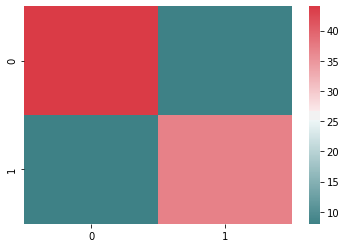

In [74]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

present_class_list=np.unique(y_test)

# Confusion Matrix
conf_mat=confusion_matrix(y_test, predictions, labels=present_class_list)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_test, predictions, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_test, predictions, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_test,predictions))

import seaborn as sns
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

XGboost performs worst than CNN, let's try to tune it.

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X_vect, Y_change, test_size=0.2, random_state=56)

booster=['gbtree','gblinear', 'dart']
max_depth = [int(x) for x in np.linspace(40, 100, num = 5)]
gamma=[int(x) for x in np.linspace(0, 10, num = 4)]
min_child_weight=[int(x) for x in np.linspace(0, 10, num = 4)]


random_grid = {'booster': booster,
               'max_depth': max_depth,
               'gamma': gamma,
               'min_child_weight': min_child_weight}

xg = XGBClassifier(use_label_encoder=False)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
xg_random.fit(np.array(X_train), y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=0, max_depth=55, gamma=3, booster=gbtree .......


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:19:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=0, max_depth=55, gamma=3, booster=gbtree, total=  16.3s
[CV] min_child_weight=0, max_depth=55, gamma=3, booster=gbtree .......


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s


[11:19:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=0, max_depth=55, gamma=3, booster=gbtree, total=  18.0s
[CV] min_child_weight=0, max_depth=55, gamma=3, booster=gbtree .......
[11:20:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=0, max_depth=55, gamma=3, booster=gbtree, total=  16.3s
[CV] min_child_weight=0, max_depth=55, gamma=3, booster=gbtree .......
[11:20:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
                                   

In [79]:
clf = xg_random.best_estimator_

print(xg_random.best_params_)

predictions=clf.predict(np.array(X_test))

{'min_child_weight': 3, 'max_depth': 85, 'gamma': 0, 'booster': 'gblinear'}


f1_score for each class
[0.90566038 0.88636364]
Global f1_score
0.8967082810206716
Global accuracy
0.8969072164948454


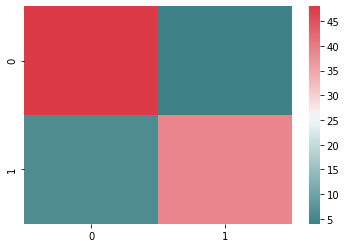

In [80]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

present_class_list=np.unique(y_test)

# Confusion Matrix
conf_mat=confusion_matrix(y_test, predictions, labels=present_class_list)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_test, predictions, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_test, predictions, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_test,predictions))

import seaborn as sns
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

Even tuned, XGBoost performs worst than the CNN.

## Using only payload portions

Up until now, we have been using whole BLE packet, meaning that the source adress was in the input data, making it fairly easy to classify. Now, let's try to use input without this piece of information: we will only be using the packet payload. \\
After studying the pcap, we saw that the packet's payload starts at byte 23, for a packet of 47 bytes. Knowing that one packet is represented here by 1520 samples, we will drop the first 744 samples at the beginning of the packet for the input.

In [92]:
#creating input for CNN: IQ values for a whole pkt     output: robot_node
X=list()
Y=list()

i=0
while i<len(idata_red.index):
    data=idata_red.iloc[i+744:i+pkt_len]
    if len(data['Time'].unique())==1:
        data=np.array(data[['real','im']], dtype='float64')
        x=data.reshape((pkt_len-744),2,1)
        X.append(x)
        Y.append(int(idata_red.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
    else:
        print('Missing!!')
    i=i+pkt_len

X=np.array(X)
Y=np.array(Y, dtype=int)

In [93]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print(unique_elements)
print(counts_elements)
#balance classes
min_samples=min(counts_elements)
print(min_samples)

thirty_six_index=np.where(Y == 36)
thirty_six_index=thirty_six_index[0][:min_samples]
X_thirty_six=X[thirty_six_index]
Y_thirty_six=Y[thirty_six_index]

thirty_seven_index=np.where(Y == 37)
thirty_seven_index=thirty_seven_index[0][:min_samples]
X_thirty_seven=X[thirty_seven_index]
Y_thirty_seven=Y[thirty_seven_index]

X=np.concatenate((X_thirty_six, X_thirty_seven))
Y=np.concatenate((Y_thirty_six, Y_thirty_seven))

[36 37]
[299 242]
242


Num GPUs Available:  1
{0: 1.0, 1: 1.0}
Epoch 1/300
4/4 [==============================] - 4s 982ms/step - loss: 0.6937 - accuracy: 0.4757 - val_loss: 0.6941 - val_accuracy: 0.4744
Epoch 2/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6861 - accuracy: 0.4951 - val_loss: 0.6940 - val_accuracy: 0.4872
Epoch 3/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6768 - accuracy: 0.5502 - val_loss: 0.6985 - val_accuracy: 0.4744
Epoch 4/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6771 - accuracy: 0.5890 - val_loss: 0.6929 - val_accuracy: 0.4872
Epoch 5/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6812 - accuracy: 0.5307 - val_loss: 0.6909 - val_accuracy: 0.5128
Epoch 6/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6766 - accuracy: 0.5534 - val_loss: 0.6887 - val_accuracy: 0.5385
Epoch 7/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6675 - accuracy: 0.5761 - val_loss: 0.6894 - val_ac

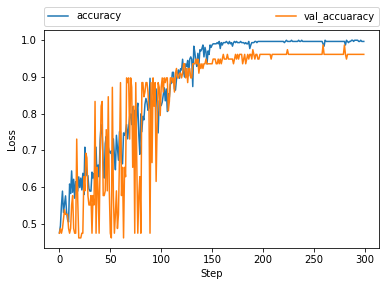

In [94]:
# trying optimal CNN

from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


batch_size=100
steps=300

Y_change=list()

#36:0, 37:1
for i in Y:
    if i==36:
        Y_change.append(0)
    elif i==37:
        Y_change.append(1)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)
input_shape=((1520-744),2,1)

model = models.Sequential()
model.add(layers.Conv2D(filters=52, kernel_size=(6, 2), padding='valid',activation='tanh', kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0),input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 1), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=162, activation='tanh'))
model.add(layers.Dropout(0.8)
)

model.add(layers.Dense(nb_class, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])



history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 class_weight=class_weights)

i = np.arange(steps)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(i, history.history['accuracy'], label='accuracy')
plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


In [95]:
predictions= model.predict(X_test)

predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]

f1_score for each class
[0.93617021 0.94      ]
Global f1_score
0.9381838122395263
Global accuracy
0.9381443298969072


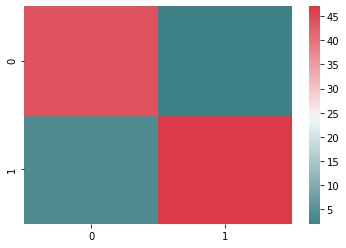

In [97]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

present_class_list=np.unique(y_test_cat)

# Confusion Matrix
conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_test_cat, predictions, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_test_cat,predictions))

import seaborn as sns
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

Using only the payload works just as well as with the full packet.

(Not surprising since it turns out that the 2 devices had the same address?).//
We have to keep in mind that since these data come from two different scenes, we cannot tell wether the classification is actually done on the device, or simply on the situation it was in.

# Three classes

In [113]:
idata_sc=idata_five[(idata_five['Scene']==36) | (idata_five['Scene']==37) | (idata_five['Scene']==35)]
print(len(idata_sc.index))

6433600


In [114]:
print(idata_sc['Scene'].value_counts())

35    3354600
36    1652920
37    1426080
Name: Scene, dtype: int64


In [115]:
print(idata_sc['Len Packet'].value_counts())

print(idata_sc['Server_id'].value_counts())

1520    5976640
1880     246280
1360     161840
880       28160
1320      17160
1760       3520
Name: Len Packet, dtype: int64
11    1770600
9     1760720
15    1515080
12    1387200
Name: Server_id, dtype: int64


In [127]:
pkt_len=1520
#using only one pkt length for the time being
idata_red=idata_sc[idata_sc['Len Packet']==pkt_len]
idata_red=idata_red[idata_red['Server_id']==9]

Using only the payload as above

In [128]:
#creating input for CNN: IQ values for a whole pkt     output: robot_node
X=list()
Y=list()

i=0
while i<len(idata_red.index):
    data=idata_red.iloc[i+744:i+pkt_len]
    if len(data['Time'].unique())==1:
        data=np.array(data[['real','im']], dtype='float64')
        x=data.reshape((pkt_len-744),2,1)
        X.append(x)
        Y.append(int(idata_red.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
    else:
        print('Missing!!')
    i=i+pkt_len

X=np.array(X)
Y=np.array(Y, dtype=int)

In [129]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print(unique_elements)
print(counts_elements)
#balance classes
min_samples=min(counts_elements)
print(min_samples)

thirty_five_index=np.where(Y == 35)
thirty_five_index=thirty_five_index[0][:min_samples]
X_thirty_five=X[thirty_five_index]
Y_thirty_five=Y[thirty_five_index]

thirty_six_index=np.where(Y == 36)
thirty_six_index=thirty_six_index[0][:min_samples]
X_thirty_six=X[thirty_six_index]
Y_thirty_six=Y[thirty_six_index]

thirty_seven_index=np.where(Y == 37)
thirty_seven_index=thirty_seven_index[0][:min_samples]
X_thirty_seven=X[thirty_seven_index]
Y_thirty_seven=Y[thirty_seven_index]

X=np.concatenate((X_thirty_five, X_thirty_six, X_thirty_seven))
Y=np.concatenate((Y_thirty_five,Y_thirty_six, Y_thirty_seven))

[35 36 37]
[522 299 242]
242


Num GPUs Available:  1
{0: 1.0, 1: 1.0, 2: 1.0}
Epoch 1/300
5/5 [==============================] - 4s 820ms/step - loss: 1.0997 - accuracy: 0.3491 - val_loss: 1.0967 - val_accuracy: 0.4741
Epoch 2/300
5/5 [==============================] - 0s 8ms/step - loss: 1.0884 - accuracy: 0.3858 - val_loss: 1.0994 - val_accuracy: 0.2931
Epoch 3/300
5/5 [==============================] - 0s 8ms/step - loss: 1.0849 - accuracy: 0.4030 - val_loss: 1.1012 - val_accuracy: 0.3276
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 1.0774 - accuracy: 0.3966 - val_loss: 1.0902 - val_accuracy: 0.3793
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 1.0739 - accuracy: 0.4267 - val_loss: 1.0968 - val_accuracy: 0.3103
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 1.0634 - accuracy: 0.4547 - val_loss: 1.0973 - val_accuracy: 0.2931
Epoch 7/300
5/5 [==============================] - 0s 8ms/step - loss: 1.0687 - accuracy: 0.4073 - val_loss: 1.0914 

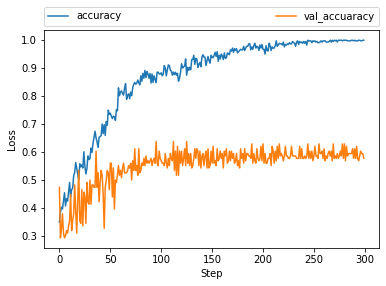

In [130]:
# trying optimal CNN

from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


batch_size=100
steps=300

Y_change=list()

#35:0, 36:1 37:2
for i in Y:
    if i==35:
        Y_change.append(0)
    elif i==36:
        Y_change.append(1)
    elif i==37:
        Y_change.append(2)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)
input_shape=((1520-744),2,1)

model = models.Sequential()
model.add(layers.Conv2D(filters=52, kernel_size=(6, 2), padding='valid',activation='tanh', kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0),input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 1), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=162, activation='tanh'))
model.add(layers.Dropout(0.8)
)

model.add(layers.Dense(nb_class, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])



history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 class_weight=class_weights)

i = np.arange(steps)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(i, history.history['accuracy'], label='accuracy')
plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


In [131]:
predictions= model.predict(X_test)

predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]

f1_score for each class
[0.47191011 0.5625     0.89719626]
Global f1_score
0.6583702273083623
Global accuracy
0.6575342465753424


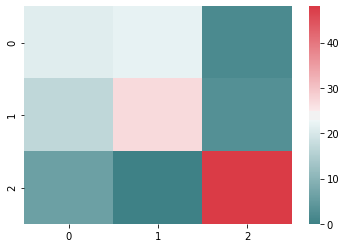

In [132]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

present_class_list=np.unique(y_test_cat)

# Confusion Matrix
conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_test_cat, predictions, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_test_cat,predictions))

import seaborn as sns
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

In [133]:
from tensorflow.keras import layers, optimizers
from kerastuner.tuners import RandomSearch, Hyperband

input_shape=((1520-744),2,1)

def build_model(h):
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=h.Int('filters_1', 2, 200,10, default=32), kernel_size=(6, 2), padding='valid',activation=h.Choice(
                'activation_1',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'), kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0),input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 1), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=h.Int('units_dense', 2, 200,10, default=100), activation=h.Choice(
                'activation_2',
                values=['relu', 'tanh', 'sigmoid'],
                default='relu')))
    model.add(layers.Dropout(
            h.Float(
                'dropout',
                min_value=0.5,
                max_value=0.9,
                default=0.7,
                step=0.1)
        )
    )

    model.add(layers.Dense(nb_class, activation='softmax'))

    hp_learning_rate = h.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=optimizers.Adam(learning_rate = hp_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
    
    return model

In [134]:
#trying first simple CNN to test if our data are ok
#using Thibaud network
from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size=100
steps=300

Y_change=list()

#36:0, 37:1
for i in Y:
    if i==35:
        Y_change.append(0)
    elif i==36:
        Y_change.append(1)
    elif i==37:
        Y_change.append(2)

Y_change=np.array(Y_change)

unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
nb_class=max(unique_elements)+1


        
        
Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)



X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)

class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_change),
                                                 Y_change)
class_weights = dict(enumerate(class_weights))


print(class_weights)

Num GPUs Available:  1
{0: 1.0, 1: 1.0, 2: 1.0}


In [135]:
tuner_rs = RandomSearch(
            build_model,
    objective='val_accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2,
            overwrite=True)

tuner_rs.search_space_summary()



tuner_rs.search(X_train, y_train, epochs=300, validation_split=0.2, verbose=1, class_weight=class_weights)

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 52s]
val_accuracy: 0.6422413885593414

Best val_accuracy So Far: 0.6637930870056152
Total elapsed time: 00h 09m 31s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters_1: 12
activation_1: tanh
units_dense: 172
activation_2: tanh
dropout: 0.6
learning_rate: 0.001
Score: 0.6637930870056152
Trial summary
Hyperparameters:
filters_1: 62
activation_1: tanh
units_dense: 182
activation_2: tanh
dropout: 0.7
learning_rate: 0.001
Score: 0.6594827473163605
Trial summary
Hyperparameters:
filters_1: 72
activation_1: relu
units_dense: 72
activation_2: tanh
dropout: 0.6
learning_rate: 0.0001
Score: 0.6422413885593414
Trial summary
Hyperparameters:
filters_1: 132
activation_1: relu
units_dense: 82
activation_2: tanh
dropout: 0.8999999999999999
learning_rate: 0.001
Score: 0.625
Trial summary
Hyperparameters:
filters_1: 42
activation_1: r